# 🔧 Install Dependencies


In [1]:
!pip install optuna category_encoders catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 13.9 MB/s eta 0:00:00


# 📁 Load Dataset

In [35]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/Coding Workspace/DSI'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import pandas as pd
import numpy as np

df_train = pd.read_csv(DATA_PATH + '/data/training_dataset.csv')
df_test = pd.read_csv(DATA_PATH + '/data/validation_set.csv')

df_test['berlangganan_deposito'] = np.nan
df = pd.concat([df_train, df_test], axis=0)

print(f'df_train shape  : {df_train.shape}')
print(f'df_test shape   : {df_test.shape}')
print(f'df shape        : {df.shape}')

df_train shape  : (22916, 22)
df_test shape   : (5729, 22)
df shape        : (28645, 22)


In [37]:
df_train.head()

,customer_number,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,...,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
0,531036,63,sosial media specialis,menikah,Pendidikan Tinggi,no,yes,no,cellular,jul,...,999,0,nonexistent,-1.7,94.215,-40.3,0.885,4991.6,Papua,1
1,999241,43,teknisi,menikah,Pendidikan Tinggi,no,yes,no,cellular,nov,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,Sulawesi,0
2,995002,29,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,yes,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,Papua,0
3,932750,40,pekerja kasar,menikah,SMA,no,no,no,telephone,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,Sumatera,1
4,684699,40,sosial media specialis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,...,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,Bali,0


# 🧹 Data Cleaning

In [41]:
import pandas as pd
from category_encoders import CatBoostEncoder

def clean_data(df, is_train=True, target_col='berlangganan_deposito', encoder_dict=None):
    '''
    Clean the dataset by:
        - Replace 999 with -1 in 'hari_sejak_kontak_sebelumnya'
        - One-hot encoding for low cardinality categorical columns
        - Map ordinal and binary categorical columns to numeric
        - Encode 'pekerjaan' with CatBoostEncoder (high cardinality)
        - Ordinal encode 'bulan_kontak_terakhir' and 'hari_kontak_terakhir'
    Parameters:
        df: pd.DataFrame, input dataframe
        is_train: bool, True for training set, False for validation/test
        target_col: str, name of the target column
        encoder_dict: dict, contains CatBoostEncoder instance (for inference phase)
    Returns:
        df_clean: pd.DataFrame, cleaned dataframe
        encoder_dict (only if is_train=True): dict with fitted encoder
    '''

    df = df.copy()

    # Replace 999 in 'hari_sejak_kontak_sebelumnya'
    df['hari_sejak_kontak_sebelumnya'] = df['hari_sejak_kontak_sebelumnya'].replace(999, -1)

    # One-hot encode: 'jenis_kontak', 'pulau', 'status_perkawinan'
    one_hot_cols = ['jenis_kontak', 'pulau', 'status_perkawinan']
    df = pd.get_dummies(df, columns=one_hot_cols, drop_first=False)

    # Drop unknown status_perkawinan (from one hot encoder)
    drop_cols = [col for col in df.columns if 'status_perkawinan_unknown' in col]
    df.drop(columns=drop_cols, inplace=True)

    # Map ordinal values
    pendidikan_mapping = {
        'unknown': -1,
        'TIDAK SEKOLAH': 0,
        'Tidak Tamat SD': 1,
        'SD': 2,
        'SMP': 3,
        'SMA': 4,
        'Diploma': 5,
        'Pendidikan Tinggi': 6
    }
    kampanye_mapping = {
        'nonexistent': -1,
        'failure': 0,
        'success': 1
    }
    binary_mapping = {'unknown': -1, 'no': 0, 'yes': 1}

    df['pendidikan'] = df['pendidikan'].map(pendidikan_mapping)
    df['hasil_kampanye_sebelumnya'] = df['hasil_kampanye_sebelumnya'].map(kampanye_mapping)
    for col in ['gagal_bayar_sebelumnya', 'pinjaman_rumah', 'pinjaman_pribadi']:
        df[col] = df[col].map(binary_mapping)

    # Ordinal encode bulan & hari
    month_order = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
        'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }
    day_order = {
        'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7
    }
    df['bulan_kontak_terakhir'] = df['bulan_kontak_terakhir'].map(month_order)
    df['hari_kontak_terakhir'] = df['hari_kontak_terakhir'].map(day_order)

    # Target encoding untuk 'pekerjaan'
    # if is_train:
    #     encoder_dict = {}
    #     cbe = CatBoostEncoder(cols=['pekerjaan'], random_state=42)
    #     df['pekerjaan'] = cbe.fit_transform(df['pekerjaan'], df[target_col])
    #     encoder_dict['pekerjaan'] = cbe
    #     return df, encoder_dict
    # else:
    #     if encoder_dict is not None and 'pekerjaan' in encoder_dict:
    #         df['pekerjaan'] = encoder_dict['pekerjaan'].transform(df['pekerjaan'])
    #     else:
    #         raise ValueError("Encoder dict must be provided in inference mode.")
    return df


In [42]:
# cleaning training data
# df_train_clean, encoder_dict = clean_data(df_train, is_train=True, target_col='berlangganan_deposito')
# df_val_clean = clean_data(df_test, is_train=False, encoder_dict=encoder_dict)

df_train_clean = clean_data(df_train, is_train=True, target_col='berlangganan_deposito')

# cleaning validation data
df_val_clean = clean_data(df_test, is_train=False)

# 🛠️ Feature Engineering

In [43]:
def feature_engineering(df):
    df = df.copy()

    # Usia
    df['usia_muda'] = (df['usia'] < 30).astype(int)
    df['usia_lansia'] = (df['usia'] > 60).astype(int)

    # Flag apakah nasabah pernah dihubungi
    df['pernah_dihubungi'] = (df['hari_sejak_kontak_sebelumnya'] != -1).astype(int)

    # Rasio kontak (tingkat keagresifan kampanye)
    df['rasio_kontak'] = df['jumlah_kontak_kampanye_ini'] / (df['jumlah_kontak_sebelumnya'] + 1)

    # Interaksi: gagal bayar dan pinjaman pribadi
    df['gagal_dan_pinjaman'] = (
        (df['gagal_bayar_sebelumnya'] == 1) &
        (df['pinjaman_pribadi'] == 1)
    ).astype(int)

    # Interaksi: total tekanan ekonomi (harga - kepercayaan)
    df['stres_ekonomi'] = df['indeks_harga_konsumen'] - df['indeks_kepercayaan_konsumen']

    # Interaksi: usia * durasi kampanye
    df['usia_x_kontak'] = df['usia'] * df['jumlah_kontak_kampanye_ini']

    # Seasonality
    df['bulan_sin'] = np.sin(2 * np.pi * df['bulan_kontak_terakhir']/12)
    df['bulan_cos'] = np.cos(2 * np.pi * df['bulan_kontak_terakhir']/12)

    return df


In [44]:
df_train_clean = feature_engineering(df_train_clean)
df_val_clean = feature_engineering(df_val_clean)

df_train_clean.shape

(22916, 41)

# 🔍 Feature Selection

In [48]:
# X_train = df_train_clean.drop(columns=['berlangganan_deposito','customer_number'])
X_train = df_train_clean.drop(columns=['berlangganan_deposito','customer_number', 'pekerjaan'])
y_train = df_train_clean['berlangganan_deposito']
X_test = df_val_clean.drop(columns=['customer_number','pekerjaan'])

## Drop highly correlated features

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

def remove_highly_correlated_features(df, threshold=0.95, plot=False, protect_cols=[]):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    to_drop = []
    for column in upper.columns:
        if column not in protect_cols and any(upper[column] > threshold):
            to_drop.append(column)

    if plot:
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
        plt.title("Correlation Matrix")
        plt.show()

    print(f"[INFO] Dropping {len(to_drop)} highly correlated features: {to_drop}")
    df_dropped = df.drop(columns=to_drop)
    return df_dropped



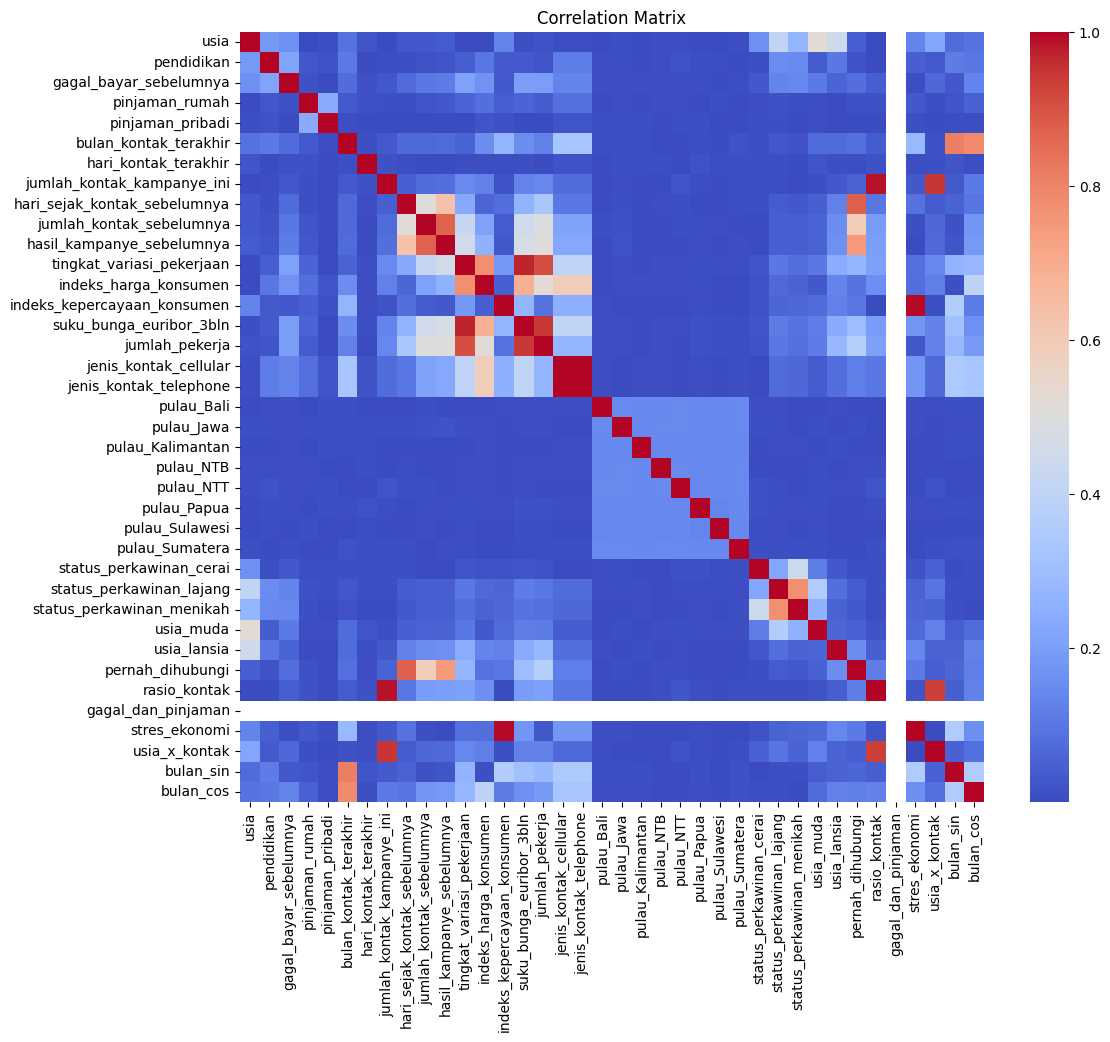

[INFO] Dropping 2 highly correlated features: ['suku_bunga_euribor_3bln', 'jenis_kontak_telephone']


In [51]:
protected = ['rasio_kontak', 'stres_ekonomi']

# Drop highly correlated features
X_train_corr = remove_highly_correlated_features(X_train, threshold=0.95, plot=True, protect_cols=protected)
X_test_corr = X_test[X_train_corr.columns]

## Get feature importance

In [52]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_lgbm_feature_importance(X, y, top_n=None, plot=True):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify= y ,random_state=42)

    model = lgb.LGBMClassifier(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    # predict proba for get AUC score
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)
    print(f"[AUC] Validation AUC: {auc_score:.4f}")

    if plot:
        top_plot = importance_df.head(top_n) if top_n else importance_df
        plt.figure(figsize=(10, 6))
        sns.barplot(data=top_plot, x='importance', y='feature')
        plt.title("LightGBM Feature Importance")
        plt.tight_layout()
        plt.show()

    return importance_df


[LightGBM] [Info] Number of positive: 2091, number of negative: 16241
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 18332, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114063 -> initscore=-2.049896
[LightGBM] [Info] Start training from score -2.049896
[AUC] Validation AUC: 0.7802


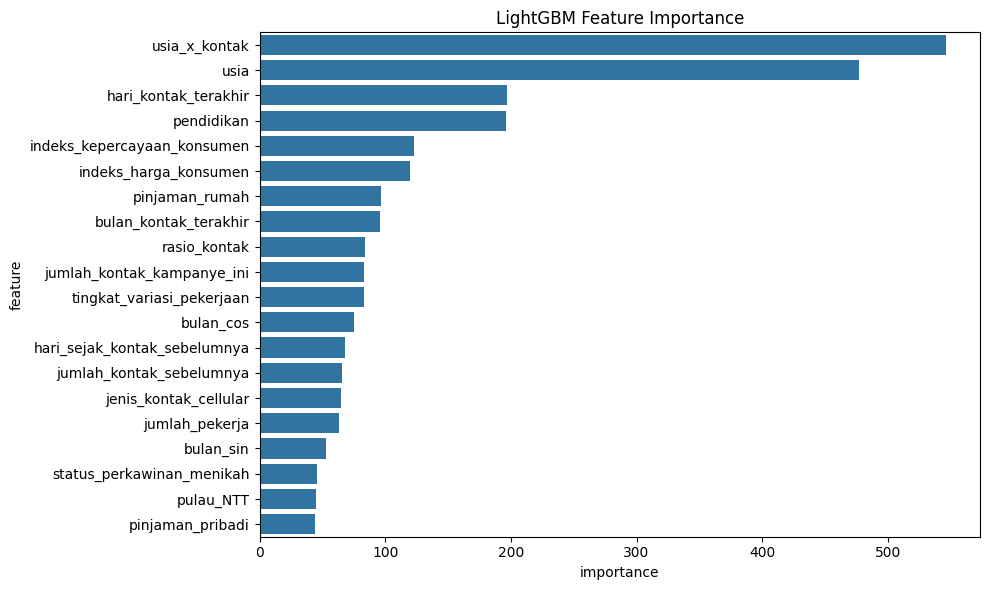

In [58]:
# Get feature importance
importance_df = get_lgbm_feature_importance(X_train_corr, y_train, top_n=20)

## Select most important features

In [59]:
def select_important_features(X, importance_df, min_importance=1):
    selected_features = importance_df[importance_df['importance'] > min_importance]['feature'].tolist()
    print(f"[INFO] Selected {len(selected_features)} features with importance > {min_importance}")
    return X[selected_features]


In [60]:
# 3. Select most important features
X_train_final = select_important_features(X_train_corr, importance_df, min_importance=10)
X_test_final = X_test_corr[X_train_final.columns]


[INFO] Selected 32 features with importance > 10


In [75]:
X_train_final['pekerjaan'] = df_train_clean['pekerjaan'].copy()
X_test_final['pekerjaan'] = df_val_clean['pekerjaan'].copy()

df_train_clean.shape, X_train_final.shape

((22916, 41), (22916, 33))

In [69]:
df_train_final = pd.concat([X_train_final, y_train], axis=1)
df_train_final.to_csv(DATA_PATH + '/data/df_train_final.csv', index=False)
X_test_final.to_csv(DATA_PATH + '/data/df_test_final.csv', index=False)

print("df_train_final saved to:", DATA_PATH + '/data/df_train_final.csv')
print("X_test_final saved to:", DATA_PATH + '/data/df_test_final.csv')

df_train_final saved to: /content/drive/MyDrive/Coding Workspace/DSI/data/df_train_final.csv
X_test_final saved to: /content/drive/MyDrive/Coding Workspace/DSI/data/df_test_final.csv


# 🧪 Hyperparameter Tuning (optuna)

Hyperparameter tuning for three tree-based models: LGBM, XGBoost, and CatBoost.

## LGBM

In [73]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
import optuna

In [88]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import numpy as np
from imblearn.over_sampling import SMOTENC

# Inisialisasi study
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)

# Hitung scale_pos_weight = negatif / positif
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

def objective(trial, X=X_train_final, y=y_train):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'scale_pos_weight': scale_pos_weight,
        'n_estimators': 2000,  # Digunakan dengan early_stopping

        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 2.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 2.0),
    }


    scores = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Tentukan indeks kolom kategorikal (yang ordinal tetapi kategori secara semantik)
    categorical_features = ['pendidikan', 'bulan_kontak_terakhir', 'hari_kontak_terakhir']
    cat_indices = [X.columns.get_loc(col) for col in categorical_features]

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        X_train_cv, X_valid_cv = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[valid_idx]

        # CatBoostEncoder per fold
        cbe = CatBoostEncoder(cols=['pekerjaan'], random_state=42)
        X_train_cv['pekerjaan'] = cbe.fit_transform(X_train_cv['pekerjaan'], y_train_cv)
        X_valid_cv['pekerjaan'] = cbe.transform(X_valid_cv['pekerjaan'])

        # Terapkan SMOTENC hanya pada data latih
        smote = SMOTENC(categorical_features=cat_indices, random_state=42)
        X_train_cv_res, y_train_cv_res = smote.fit_resample(X_train_cv, y_train_cv)


        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train_cv, y_train_cv,
            eval_set=[(X_valid_cv, y_valid_cv)],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
        )

        preds = model.predict_proba(X_valid_cv)[:, 1]
        auc = roc_auc_score(y_valid_cv, preds)
        scores.append(auc)

        # Pruning manual
        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(scores)

# Jalankan optimasi
study.optimize(lambda trial: objective(trial), n_trials=100, show_progress_bar=True)


[I 2025-06-04 15:12:40,562] A new study created in memory with name: no-name-764f1aed-6243-4a4a-ae5a-65b2303293e0


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-04 15:12:53,396] Trial 0 finished with value: 0.7922737581903775 and parameters: {'learning_rate': 0.023688639503640783, 'num_leaves': 77, 'max_depth': 8, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 1, 'min_child_samples': 12, 'lambda_l1': 1.7323522915498704, 'lambda_l2': 1.2022300234864176}. Best is trial 0 with value: 0.7922737581903775.
[I 2025-06-04 15:13:03,891] Trial 1 finished with value: 0.7944338133327986 and parameters: {'learning_rate': 0.051059032093947576, 'num_leaves': 21, 'max_depth': 10, 'feature_fraction': 0.9329770563201687, 'bagging_fraction': 0.6849356442713105, 'bagging_freq': 1, 'min_child_samples': 17, 'lambda_l1': 0.6084844859190754, 'lambda_l2': 1.0495128632644757}. Best is trial 1 with value: 0.7944338133327986.
[I 2025-06-04 15:13:16,832] Trial 2 finished with value: 0.7941506019254299 and parameters: {'learning_rate': 0.027036160666620016, 'num_leaves': 37, 'max_depth': 7, 'feature_fraction': 0.6

In [89]:
print("Best params:", study.best_params)
print("Best AUC:", study.best_value)

Best params: {'learning_rate': 0.044167537658806336, 'num_leaves': 38, 'max_depth': 5, 'feature_fraction': 0.6478043535801732, 'bagging_fraction': 0.8237103671209042, 'bagging_freq': 4, 'min_child_samples': 23, 'lambda_l1': 0.8560415565533104, 'lambda_l2': 1.0182550917756634}
Best AUC: 0.7964828106203596


In [78]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    RocCurveDisplay, precision_recall_curve, auc
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Split data untuk evaluasi (karena X_test_final tidak punya label)
X_train_eval, X_valid_eval, y_train_eval, y_valid_eval = train_test_split(
    X_train_final, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# CatBoostEncoder per fold
cbe = CatBoostEncoder(cols=['pekerjaan'], random_state=42)
X_train_eval['pekerjaan'] = cbe.fit_transform(X_train_eval['pekerjaan'], y_train_eval)
X_valid_eval['pekerjaan'] = cbe.transform(X_valid_eval['pekerjaan'])


# Ambil best hyperparameters dari study Optuna
best_params = study.best_trial.params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'scale_pos_weight': scale_pos_weight
})

# Latih model
model_final = lgb.LGBMClassifier(**best_params)
model_final.fit(X_train_eval, y_train_eval)

# Prediksi probabilitas dan label
y_pred_proba = model_final.predict_proba(X_valid_eval)[:, 1]
y_pred_label = (y_pred_proba > 0.5).astype(int)



In [79]:
# 1. ROC AUC
auc_score = roc_auc_score(y_valid_eval, y_pred_proba)
print(f"[AUC] Validation AUC: {auc_score:.4f}")

# 2. Classification Report
print("\n[Classification Report]")
print(classification_report(y_valid_eval, y_pred_label))


[AUC] Validation AUC: 0.7881

[Classification Report]
              precision    recall  f1-score   support

           0       0.95      0.85      0.89      4061
           1       0.35      0.65      0.46       523

    accuracy                           0.82      4584
   macro avg       0.65      0.75      0.68      4584
weighted avg       0.88      0.82      0.84      4584




[Confusion Matrix]


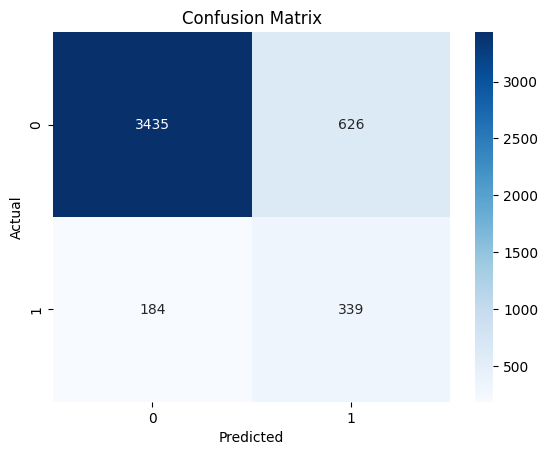


[ROC Curve]


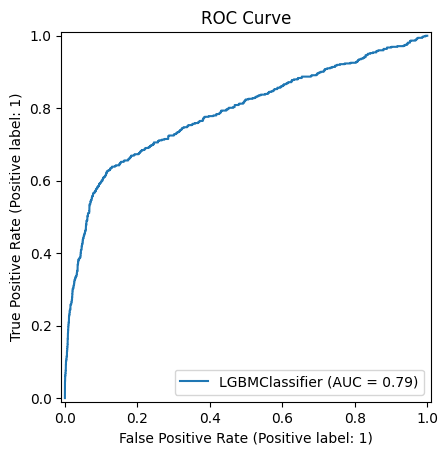


[Precision-Recall Curve]


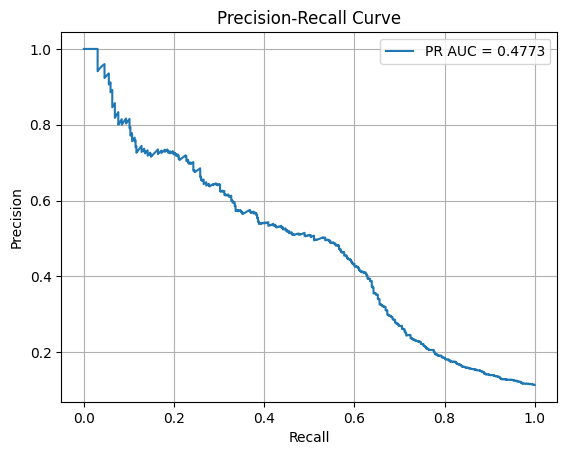

In [80]:
# 3. Confusion Matrix
print("\n[Confusion Matrix]")
cm = confusion_matrix(y_valid_eval, y_pred_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. ROC Curve
print("\n[ROC Curve]")
RocCurveDisplay.from_estimator(model_final, X_valid_eval, y_valid_eval)
plt.title("ROC Curve")
plt.show()

# 5. Precision-Recall Curve
print("\n[Precision-Recall Curve]")
precision, recall, _ = precision_recall_curve(y_valid_eval, y_pred_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


[Feature Importance]


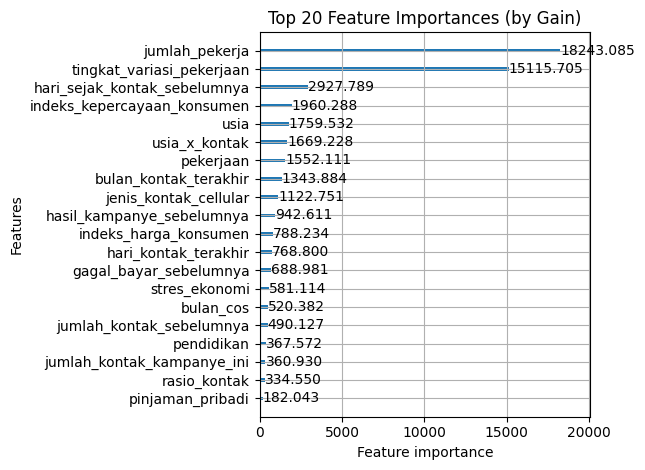

In [81]:

# 6. Feature Importance
print("\n[Feature Importance]")
lgb.plot_importance(model_final, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances (by Gain)")
plt.tight_layout()
plt.show()

Validation ROC AUC: 0.7825


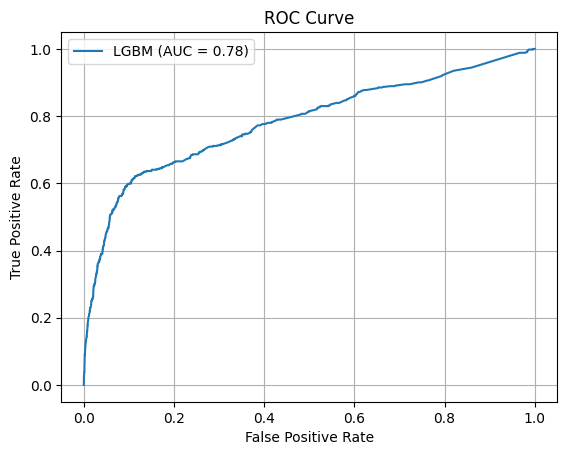

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

X_train, X_val, y_train, y_val = train_test_split(
    X_train_final, y_train, test_size=0.2, stratify=y_train, random_state=42
)


base_model = LGBMClassifier(random_state=42, n_estimators=100)
model = CalibratedClassifierCV(base_model, method='isotonic', cv=3)
model.fit(X_train, y_train)

# -------------------------------
# 4. Evaluation (ROC AUC)
# -------------------------------
y_val_proba = model.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_val_proba)
print(f"Validation ROC AUC: {auc_score:.4f}")

# -------------------------------
# 5. Plot ROC Curve
# -------------------------------
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"LGBM (AUC = {auc_score:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

## XGBoost

In [ ]:
!pip install -U xgboost

  Using cached xgboost-3.0.1-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.1-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6


In [82]:
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
import numpy as np

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))

def objective(trial, X=X_train_final, y=y_train):
    params = {
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'auc',
        'verbosity': 0
    }

    scores = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        X_train_cv, X_valid_cv = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[valid_idx]

        # CatBoostEncoder per fold
        cbe = CatBoostEncoder(cols=['pekerjaan'], random_state=42)
        X_train_cv['pekerjaan'] = cbe.fit_transform(X_train_cv['pekerjaan'], y_train_cv)
        X_valid_cv['pekerjaan'] = cbe.transform(X_valid_cv['pekerjaan'])

        model = XGBClassifier(**params)
        model.set_params(callbacks=[EarlyStopping(rounds=100)])

        model.fit(X_train_cv, y_train_cv, eval_set=[(X_valid_cv, y_valid_cv)], verbose=False)

        preds = model.predict_proba(X_valid_cv)[:, 1]
        auc = roc_auc_score(y_valid_cv, preds)
        scores.append(auc)

        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(scores)

study.optimize(objective, n_trials=100, show_progress_bar=True)


[I 2025-06-04 14:41:00,740] A new study created in memory with name: no-name-18691ea1-4436-4615-abab-127780593b82


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-04 14:41:07,414] Trial 0 finished with value: 0.7892716724664977 and parameters: {'learning_rate': 0.030710573677773714, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 2.993292420985183, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'reg_alpha': 0.2904180608409973, 'reg_lambda': 4.330880728874676}. Best is trial 0 with value: 0.7892716724664977.
[I 2025-06-04 14:41:14,731] Trial 1 finished with value: 0.789849926310431 and parameters: {'learning_rate': 0.06054365855469246, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 4.8495492608099715, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'reg_alpha': 0.9091248360355031, 'reg_lambda': 0.9170225492671691}. Best is trial 1 with value: 0.789849926310431.
[I 2025-06-04 14:41:20,454] Trial 2 finished with value: 0.7922056035075066 and parameters: {'learning_rate': 0.024878734419814436, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 1.4561457009902097, 'subsample': 0.80592644736

In [83]:
print("Best params:", study.best_params)
print("Best AUC:", study.best_value)

Best params: {'learning_rate': 0.03333038082993617, 'max_depth': 4, 'min_child_weight': 8, 'gamma': 1.448011255370878, 'subsample': 0.7131480463324854, 'colsample_bytree': 0.6868904751772935, 'reg_alpha': 2.061542781192091, 'reg_lambda': 0.9412160822045316}
Best AUC: 0.7936482875758465


[AUC] Validation AUC: 0.7876

[Classification Report]
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      4061
           1       0.36      0.64      0.46       523

    accuracy                           0.83      4584
   macro avg       0.65      0.75      0.68      4584
weighted avg       0.88      0.83      0.85      4584


[Confusion Matrix]


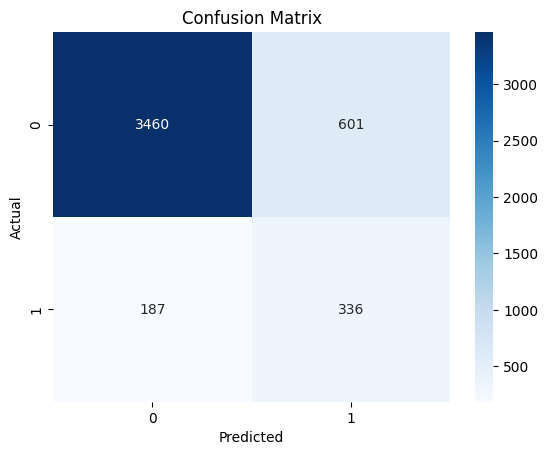

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    RocCurveDisplay, precision_recall_curve, auc
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Split data untuk evaluasi
X_train_eval, X_valid_eval, y_train_eval, y_valid_eval = train_test_split(
    X_train_final, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Hitung ulang scale_pos_weight
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# Ambil best hyperparameters dari Optuna
best_params = study.best_trial.params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    'verbosity': 0
})

# Buat dan latih model
model_final = xgb.XGBClassifier(**best_params)
model_final.fit(X_train_eval, y_train_eval)

# Prediksi probabilitas dan label
y_pred_proba = model_final.predict_proba(X_valid_eval)[:, 1]
y_pred_label = (y_pred_proba > 0.5).astype(int)

# 1. ROC AUC
auc_score = roc_auc_score(y_valid_eval, y_pred_proba)
print(f"[AUC] Validation AUC: {auc_score:.4f}")

# 2. Classification Report
print("\n[Classification Report]")
print(classification_report(y_valid_eval, y_pred_label))

# 3. Confusion Matrix
print("\n[Confusion Matrix]")
cm = confusion_matrix(y_valid_eval, y_pred_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


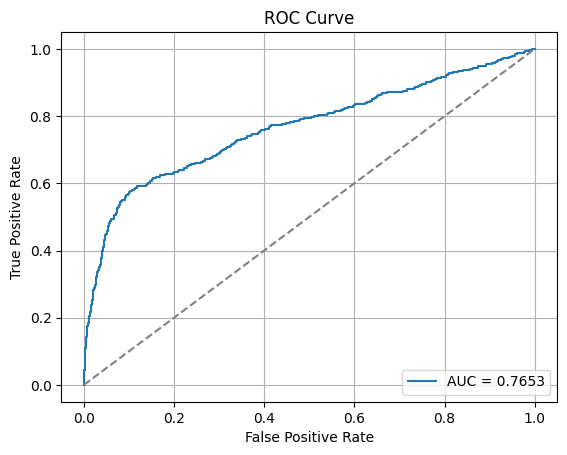

In [ ]:
from sklearn.metrics import roc_curve

# Hitung nilai FPR, TPR, dan thresholds
fpr, tpr, thresholds = roc_curve(y_valid_eval, y_pred_proba)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:

# 4. ROC Curve
print("\n[ROC Curve]")
RocCurveDisplay.from_estimator(model_final, X_valid_eval, y_valid_eval)
plt.title("ROC Curve")
plt.show()

# 5. Precision-Recall Curve
print("\n[Precision-Recall Curve]")
precision, recall, _ = precision_recall_curve(y_valid_eval, y_pred_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# 6. Feature Importance
print("\n[Feature Importance]")
xgb.plot_importance(model_final, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances (by Gain)")
plt.tight_layout()
plt.show()


## Catboost

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.5 MB/s eta 0:00:00


In [84]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
import numpy as np

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))

def catboost_objective(trial, X=X_train_final, y=y_train):
    params = {
        'iterations': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'eval_metric': 'AUC',
        'loss_function': 'Logloss',
        'verbose': 0,
        'scale_pos_weight': scale_pos_weight,
        'random_seed': 42,
    }

    scores = []
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        X_train_cv, X_valid_cv = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[valid_idx]

        # CatBoostEncoder per fold
        cbe = CatBoostEncoder(cols=['pekerjaan'], random_state=42)
        X_train_cv['pekerjaan'] = cbe.fit_transform(X_train_cv['pekerjaan'], y_train_cv)
        X_valid_cv['pekerjaan'] = cbe.transform(X_valid_cv['pekerjaan'])

        train_pool = Pool(X_train_cv, y_train_cv)
        valid_pool = Pool(X_valid_cv, y_valid_cv)

        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=100)

        preds = model.predict_proba(X_valid_cv)[:, 1]
        auc = roc_auc_score(y_valid_cv, preds)
        scores.append(auc)

        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(scores)

study.optimize(catboost_objective, n_trials=100, show_progress_bar=True)


[I 2025-06-04 14:49:54,621] A new study created in memory with name: no-name-f21b5baa-65fe-4c9b-8869-9e5ecdaba80b


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-04 14:50:47,624] Trial 0 finished with value: 0.7970178861047833 and parameters: {'learning_rate': 0.030710573677773714, 'depth': 10, 'l2_leaf_reg': 7.587945476302646, 'bagging_temperature': 0.5986584841970366, 'random_strength': 0.15601864044243652, 'border_count': 66}. Best is trial 0 with value: 0.7970178861047833.
[I 2025-06-04 14:52:54,481] Trial 1 finished with value: 0.7952488858945959 and parameters: {'learning_rate': 0.011900590783184251, 'depth': 10, 'l2_leaf_reg': 6.41003510568888, 'bagging_temperature': 0.7080725777960455, 'random_strength': 0.020584494295802447, 'border_count': 249}. Best is trial 0 with value: 0.7970178861047833.
[I 2025-06-04 14:53:09,042] Trial 2 finished with value: 0.7977065901887849 and parameters: {'learning_rate': 0.12106896936002161, 'depth': 5, 'l2_leaf_reg': 2.636424704863906, 'bagging_temperature': 0.18340450985343382, 'random_strength': 0.3042422429595377, 'border_count': 149}. Best is trial 2 with value: 0.7977065901887849.
[I 2025

In [85]:
print("Best params:", study.best_params)
print("Best AUC:", study.best_value)

Best params: {'learning_rate': 0.03647316284911211, 'depth': 6, 'l2_leaf_reg': 6.506676052501415, 'bagging_temperature': 0.13949386065204183, 'random_strength': 0.29214464853521815, 'border_count': 114}
Best AUC: 0.7987106165119233


[AUC] Validation AUC: 0.7951

[Classification Report]
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      4061
           1       0.34      0.66      0.44       523

    accuracy                           0.81      4584
   macro avg       0.64      0.74      0.67      4584
weighted avg       0.88      0.81      0.84      4584


[Confusion Matrix]


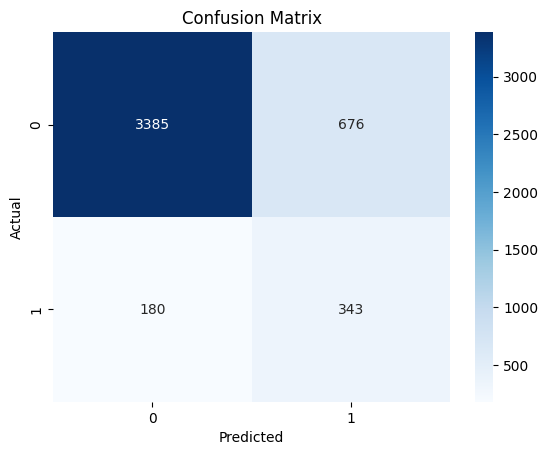


[ROC Curve]


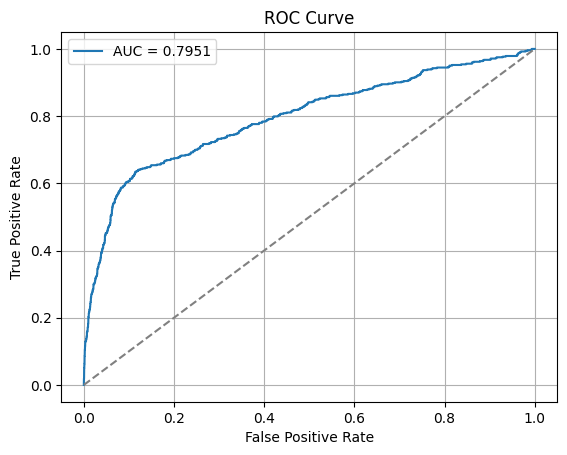


[Precision-Recall Curve]


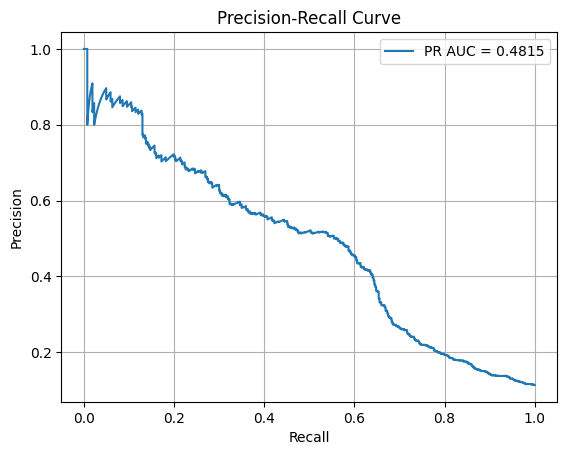


[Feature Importance]


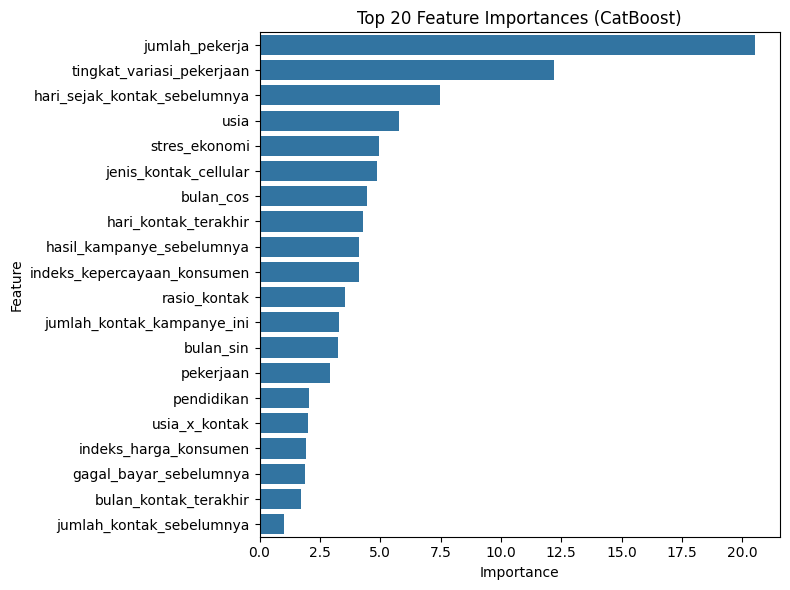

In [86]:
from catboost import CatBoostClassifier
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, auc, roc_curve
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Split data untuk evaluasi
X_train_eval, X_valid_eval, y_train_eval, y_valid_eval = train_test_split(
    X_train_final, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Gunakan best params dari Optuna
cat_params = {
    'learning_rate': 0.12106896936002161,
    'depth': 5,
    'l2_leaf_reg': 2.636424704863906,
    'bagging_temperature': 0.18340450985343382,
    'random_strength': 0.3042422429595377,
    'border_count': 149,
    'scale_pos_weight': scale_pos_weight,  # untuk class imbalance
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'random_seed': 42,
    'verbose': False
}

# CatBoostEncoder per fold
cbe = CatBoostEncoder(cols=['pekerjaan'], random_state=42)
X_train_eval['pekerjaan'] = cbe.fit_transform(X_train_eval['pekerjaan'], y_train_eval)
X_valid_eval['pekerjaan'] = cbe.transform(X_valid_eval['pekerjaan'])


# Inisialisasi dan latih model
model_final = CatBoostClassifier(**cat_params)
model_final.fit(X_train_eval, y_train_eval, eval_set=(X_valid_eval, y_valid_eval), early_stopping_rounds=50)

# Prediksi probabilitas dan label
y_pred_proba = model_final.predict_proba(X_valid_eval)[:, 1]
y_pred_label = (y_pred_proba > 0.5).astype(int)

# 1. ROC AUC
auc_score = roc_auc_score(y_valid_eval, y_pred_proba)
print(f"[AUC] Validation AUC: {auc_score:.4f}")

# 2. Classification Report
print("\n[Classification Report]")
print(classification_report(y_valid_eval, y_pred_label))

# 3. Confusion Matrix
print("\n[Confusion Matrix]")
cm = confusion_matrix(y_valid_eval, y_pred_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. ROC Curve
print("\n[ROC Curve]")
fpr, tpr, _ = roc_curve(y_valid_eval, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 5. Precision-Recall Curve
print("\n[Precision-Recall Curve]")
precision, recall, _ = precision_recall_curve(y_valid_eval, y_pred_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# 6. Feature Importance
print("\n[Feature Importance]")
feature_importances = model_final.get_feature_importance()
sorted_idx = np.argsort(feature_importances)[-20:][::-1]
top_features = X_train_eval.columns[sorted_idx]

plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances[sorted_idx], y=top_features)
plt.title("Top 20 Feature Importances (CatBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## GBC

In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# Hitung rasio imbalance
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)

def objective(trial, X=X_train_final, y=y_train):
    params = {
        'loss': 'log_loss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=10),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    }

    scores = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        X_train_cv, X_valid_cv = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[valid_idx]

        sample_weight = np.where(y_train_cv == 1, scale_pos_weight, 1)

        model = GradientBoostingClassifier(**params, random_state=42)
        model.fit(X_train_cv, y_train_cv, sample_weight=sample_weight)

        preds = model.predict_proba(X_valid_cv)[:, 1]
        auc = roc_auc_score(y_valid_cv, preds)
        scores.append(auc)

        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(scores)

study.optimize(lambda trial: objective(trial), n_trials=50, show_progress_bar=True)
print("Best params:", study.best_params)


[I 2025-06-02 04:54:57,562] A new study created in memory with name: no-name-cf7273a4-f061-42c6-be90-bcfb610dde31


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-02 04:55:33,573] Trial 0 finished with value: 0.7685694320276864 and parameters: {'learning_rate': 0.04, 'n_estimators': 200, 'max_depth': 8, 'subsample': 0.8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7685694320276864.
[I 2025-06-02 04:55:58,036] Trial 1 finished with value: 0.7477250199766413 and parameters: {'learning_rate': 0.09, 'n_estimators': 140, 'max_depth': 8, 'subsample': 0.6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7685694320276864.
[I 2025-06-02 04:56:18,209] Trial 2 finished with value: 0.7880766406791475 and parameters: {'learning_rate': 0.02, 'n_estimators': 70, 'max_depth': 5, 'subsample': 0.8, 'max_features': None}. Best is trial 2 with value: 0.7880766406791475.
[I 2025-06-02 04:56:26,269] Trial 3 finished with value: 0.7916976874161759 and parameters: {'learning_rate': 0.02, 'n_estimators': 90, 'max_depth': 5, 'subsample': 0.8, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7916976874161759.
[I 2025-06-02 04:56:43,002] 

In [ ]:
# Tampilkan hasil terbaik
print("Best trial:")
trial = study.best_trial
print(f"  AUC: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  AUC: 0.7920528838259491
  Params: 
    learning_rate: 0.01
    n_estimators: 120
    max_depth: 8
    subsample: 0.7
    max_features: log2


# ⚔️ Compare Models

In [109]:
# Hitung scale_pos_weight = negatif / positif
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# === 1. LightGBM (Updated) ===
lgb_params = {
    'learning_rate': 0.044167537658806336,
    'num_leaves': 38,
    'max_depth': 5,
    'feature_fraction': 0.6478043535801732,
    'bagging_fraction': 0.8237103671209042,
    'bagging_freq': 4,
    'min_child_samples': 23,
    'lambda_l1': 0.8560415565533104,
    'lambda_l2': 1.0182550917756634,

    'objective': 'binary',
    'n_estimators': 2000,
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1
}

# === 2. XGBoost ===
xgb_params = {
    'learning_rate': 0.03333038082993617,
    'max_depth': 4,
    'min_child_weight': 8,
    'gamma': 1.448011255370878,
    'subsample': 0.7131480463324854,
    'colsample_bytree': 0.6868904751772935,
    'reg_alpha': 2.061542781192091,
    'reg_lambda': 0.9412160822045316,

    'objective': 'binary:logistic',
    'n_estimators': 2000,
    'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight,  # Jika masih ingin digunakan
    'verbosity': 0,
    'random_state': 42,
    'n_jobs': -1
}

# === 3. CatBoost ===
cat_params = {
    'learning_rate': 0.03647316284911211,
    'depth': 6,
    'l2_leaf_reg': 6.506676052501415,
    'bagging_temperature': 0.13949386065204183,
    'random_strength': 0.29214464853521815,
    'border_count': 114,

    'scale_pos_weight': scale_pos_weight,  # Jika masih ingin digunakan
    'iterations': 2000,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'random_seed': 42,
    'verbose': False
}

gbc_params = {
    'loss': 'log_loss',
    'learning_rate': 0.01,
    'n_estimators': 120,
    'max_depth': 8,
    'subsample': 0.7,
    'max_features': 'log2',
    'random_state': 42,
}

In [91]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import lightgbm as lgb
import xgboost as xgb
from xgboost.callback import EarlyStopping
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

## Check folding each model (get n_estimator)

In [110]:
def evaluate_model_stability_lgb(model_class, model_params, X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    aucs = []
    best_iterations = []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # CatBoostEncoder per fold
        cbe = CatBoostEncoder(cols=['pekerjaan'], random_state=42)
        X_train['pekerjaan'] = cbe.fit_transform(X_train['pekerjaan'], y_train)
        X_valid['pekerjaan'] = cbe.transform(X_valid['pekerjaan'])

        model = model_class(**model_params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
        )
        y_proba = model.predict_proba(X_valid)[:, 1]
        aucs.append(roc_auc_score(y_valid, y_proba))
        best_iterations.append(model.best_iteration_)

    avg_best_iter = int(np.mean(best_iterations))
    print(f"AUC mean: {np.mean(aucs):.4f}, std: {np.std(aucs):.4f}")
    print(f"Best iteration (average): {avg_best_iter}")
    return avg_best_iter


In [111]:
evaluate_model_stability_lgb(lgb.LGBMClassifier, lgb_params, X_train_final, y_train, n_splits=5)


AUC mean: 0.7924, std: 0.0099
Best iteration (average): 72


72

In [114]:
def evaluate_model_stability_xgb(model_class, model_params, X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    aucs = []
    best_iterations = []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # CatBoostEncoder per fold
        cbe = CatBoostEncoder(cols=['pekerjaan'], random_state=42)
        X_train['pekerjaan'] = cbe.fit_transform(X_train['pekerjaan'], y_train)
        X_valid['pekerjaan'] = cbe.transform(X_valid['pekerjaan'])

        model = model_class(**model_params)
        model.set_params(callbacks=[EarlyStopping(rounds=100)])
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        y_proba = model.predict_proba(X_valid)[:, 1]
        aucs.append(roc_auc_score(y_valid, y_proba))
        best_iterations.append(model.best_iteration)

    avg_best_iter = int(np.mean(best_iterations))
    print(f"AUC mean: {np.mean(aucs):.4f}, std: {np.std(aucs):.4f}")
    print(f"Best iteration (average): {avg_best_iter}")
    return avg_best_iter

evaluate_model_stability_xgb(xgb.XGBClassifier, xgb_params | {'use_label_encoder': False}, X_train_final, y_train, n_splits=5)

AUC mean: 0.7924, std: 0.0101
Best iteration (average): 108


108

In [115]:
from catboost import CatBoostClassifier, Pool

def evaluate_model_stability_catboost(model_class, model_params, X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    aucs = []
    best_iterations = []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # CatBoostEncoder per fold
        cbe = CatBoostEncoder(cols=['pekerjaan'], random_state=42)
        X_train['pekerjaan'] = cbe.fit_transform(X_train['pekerjaan'], y_train)
        X_valid['pekerjaan'] = cbe.transform(X_valid['pekerjaan'])

        train_pool = Pool(X_train, y_train)
        valid_pool = Pool(X_valid, y_valid)

        model = CatBoostClassifier(**model_params)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=100)
        y_proba = model.predict_proba(X_valid)[:, 1]
        aucs.append(roc_auc_score(y_valid, y_proba))
        best_iterations.append(model.get_best_iteration())

    avg_best_iter = int(np.mean(best_iterations))
    print(f"AUC mean: {np.mean(aucs):.4f}, std: {np.std(aucs):.4f}")
    print(f"Best iteration (average): {avg_best_iter}")
    return avg_best_iter

evaluate_model_stability_catboost(CatBoostClassifier, cat_params, X_train_final, y_train, n_splits=5)

AUC mean: 0.7955, std: 0.0114
Best iteration (average): 88


88

## AUC curve

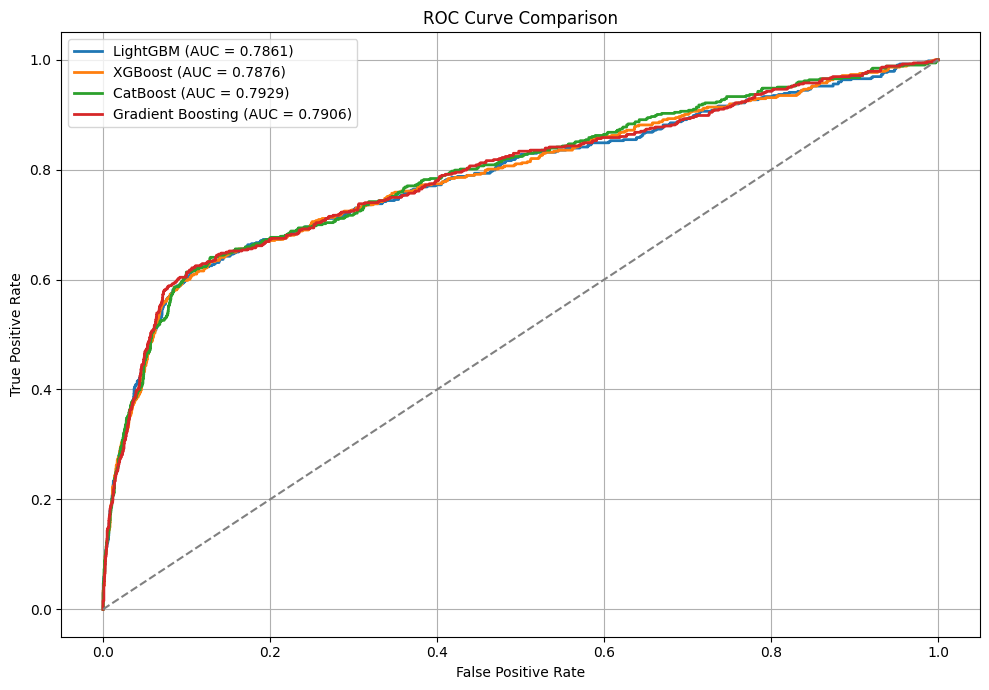

In [117]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import lightgbm as lgb
import xgboost as xgb
from xgboost.callback import EarlyStopping
from catboost import CatBoostClassifier

# Split data
X_train_eval, X_valid_eval, y_train_eval, y_valid_eval = train_test_split(
    X_train_final, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# CatBoostEncoder per fold
cbe = CatBoostEncoder(cols=['pekerjaan'], random_state=42)
X_train_eval['pekerjaan'] = cbe.fit_transform(X_train_eval['pekerjaan'], y_train_eval)
X_valid_eval['pekerjaan'] = cbe.transform(X_valid_eval['pekerjaan'])

# === 1. LightGBM ===
lgb_params.update({
    'n_estimators': 72,
})
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_train_eval, y_train_eval)
lgb_proba = lgb_model.predict_proba(X_valid_eval)[:, 1]
fpr_lgb, tpr_lgb, _ = roc_curve(y_valid_eval, lgb_proba)
auc_lgb = auc(fpr_lgb, tpr_lgb)

# === 2. XGBoost ===
xgb_params.update({
    'n_estimators': 108
})

xgb_model = xgb.XGBClassifier(use_label_encoder=False, **xgb_params)
xgb_model.fit(X_train_eval, y_train_eval)
xgb_proba = xgb_model.predict_proba(X_valid_eval)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_valid_eval, xgb_proba)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# === 3. CatBoost ===
cat_params.update({
    'iterations': 88
})
cat_model = CatBoostClassifier(**cat_params)
cat_model.fit(X_train_eval, y_train_eval, eval_set=(X_valid_eval, y_valid_eval), early_stopping_rounds=50)
cat_proba = cat_model.predict_proba(X_valid_eval)[:, 1]
fpr_cat, tpr_cat, _ = roc_curve(y_valid_eval, cat_proba)
auc_cat = auc(fpr_cat, tpr_cat)

# === 4. Gradient Boosting ===
sample_weight = np.where(y_train_eval == 1, scale_pos_weight, 1)
gbc_model = GradientBoostingClassifier(**gbc_params)
gbc_model.fit(X_train_eval, y_train_eval, sample_weight=sample_weight)
gbc_proba = gbc_model.predict_proba(X_valid_eval)[:, 1]
fpr_gbc, tpr_gbc, _ = roc_curve(y_valid_eval, gbc_proba)
auc_gbc = auc(fpr_gbc, tpr_gbc)

# === Plot ROC Curve ===
plt.figure(figsize=(10, 7))
plt.plot(fpr_lgb, tpr_lgb, label=f"LightGBM (AUC = {auc_lgb:.4f})", linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.4f})", linewidth=2)
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost (AUC = {auc_cat:.4f})", linewidth=2)
plt.plot(fpr_gbc, tpr_gbc, label=f"Gradient Boosting (AUC = {auc_gbc:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Learning Curve

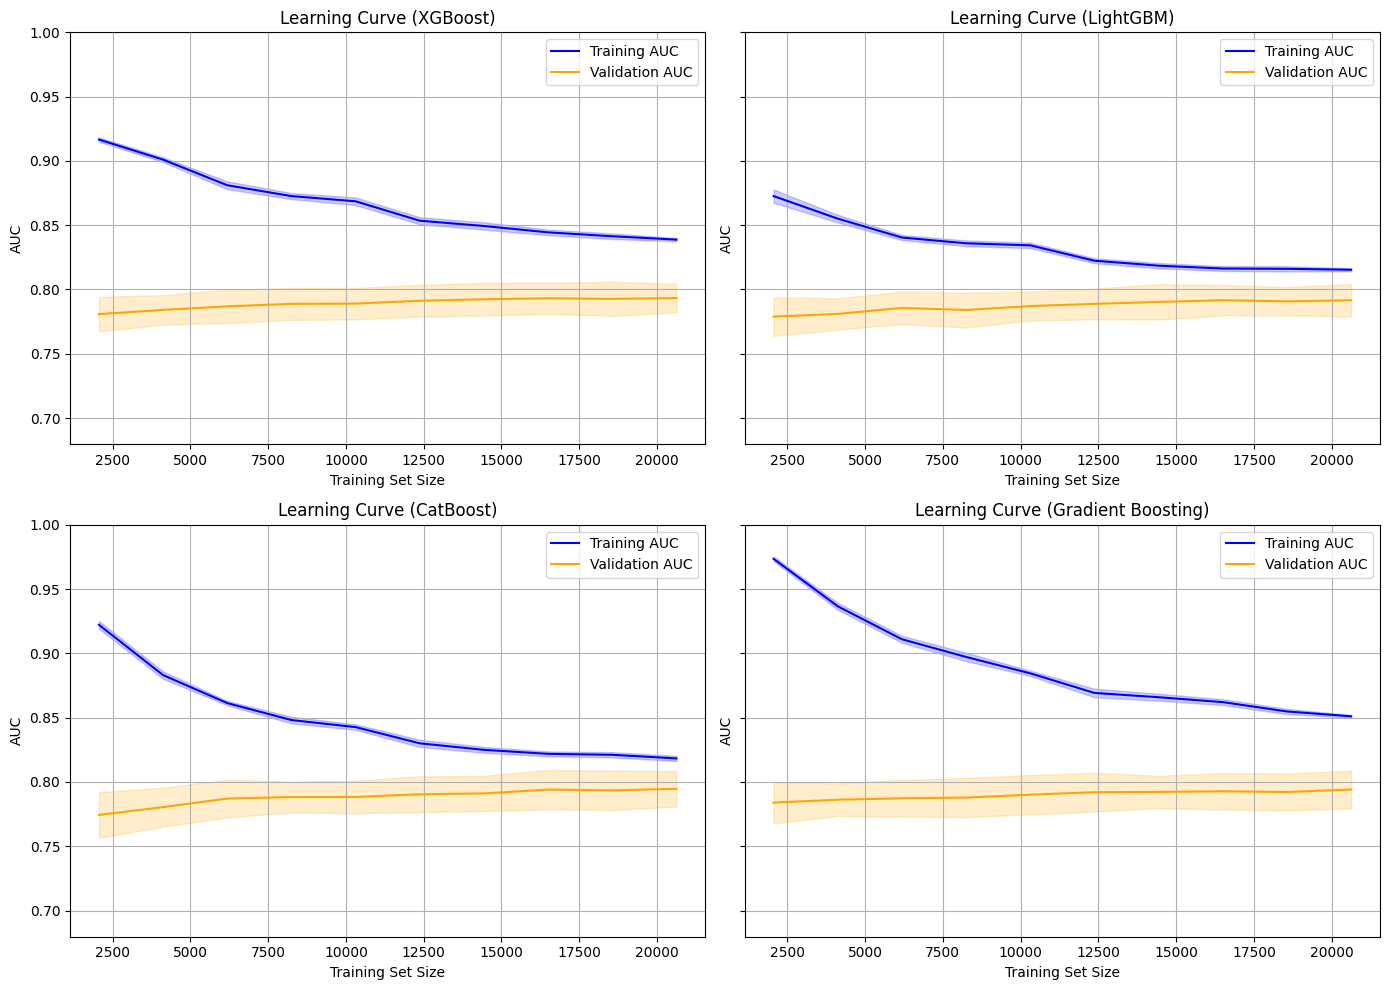

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold
import numpy as np

# Define the models and their names
models = {
    "XGBoost": xgb_model,
    "LightGBM": lgb_model,
    "CatBoost": cat_model,
    "Gradient Boosting": gbc_model
}

# Create a figure with 3 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)  # Added sharey=True
axes = axes.flatten()  # Flatten for easy iteration

# Find global min/max AUC values to standardize y-axis
all_auc_values = []

for model_name, model in models.items():
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator=model,
        X=X_train_final,
        y=y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1
    )
    all_auc_values.extend(train_scores.flatten())
    all_auc_values.extend(valid_scores.flatten())

# Calculate global y-axis limits with some padding
y_min = max(0.0, np.min(all_auc_values) - 0.05)
y_max = min(1.0, np.max(all_auc_values) + 0.05)

# Loop through each model and plot learning curves
for ax, (model_name, model) in zip(axes, models.items()):
    # Compute learning curve
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator=model,
        X=X_train_final,
        y=y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1
    )

    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # Plot training and validation curves
    ax.plot(train_sizes, train_mean, label='Training AUC', color='blue')
    ax.fill_between(
        train_sizes, train_mean - train_std, train_mean + train_std,
        alpha=0.2, color='blue'
    )
    ax.plot(train_sizes, valid_mean, label='Validation AUC', color='orange')
    ax.fill_between(
        train_sizes, valid_mean - valid_std, valid_mean + valid_std,
        alpha=0.2, color='orange'
    )

    # Set consistent y-axis limits
    ax.set_ylim(y_min, y_max)

    # Customize subplot
    ax.set_title(f'Learning Curve ({model_name})')
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('AUC')
    ax.legend(loc='best')
    ax.grid()

plt.tight_layout()
plt.show()

## evaluation

In [118]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, model_name, X_valid, y_valid, X_train=None):
    """
    Comprehensive evaluation for a single model
    """
    # Predict probabilities and labels
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_pred_label = (y_pred_proba > 0.5).astype(int)

    # Create figure for all plots
    plt.figure(figsize=(18, 12))

    # 1. ROC AUC and Curve
    plt.subplot(2, 2, 1)
    auc_score = roc_auc_score(y_valid, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend()
    plt.grid(True)

    # 2. Confusion Matrix
    plt.subplot(2, 2, 2)
    cm = confusion_matrix(y_valid, y_pred_label)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # 3. Precision-Recall Curve
    plt.subplot(2, 2, 3)
    precision, recall, _ = precision_recall_curve(y_valid, y_pred_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.legend()
    plt.grid(True)

    # 4. Feature Importance (if available)
    if hasattr(model, 'feature_importances_'):
        plt.subplot(2, 2, 4)
        feature_importances = model.feature_importances_
        sorted_idx = np.argsort(feature_importances)[-20:][::-1]
        top_features = X_train.columns[sorted_idx] if X_train is not None else range(len(sorted_idx))

        sns.barplot(x=feature_importances[sorted_idx], y=top_features)
        plt.title(f"{model_name} Top 20 Feature Importances")
        plt.xlabel("Importance")
        plt.ylabel("Feature")

    plt.tight_layout()
    plt.show()

    # Print metrics
    print(f"\n{'='*50}")
    print(f"Model: {model_name}")
    print(f"{'='*50}")
    print(f"[AUC] Validation AUC: {auc_score:.4f}")
    print(f"\n[Classification Report]")
    print(classification_report(y_valid, y_pred_label))
    print(f"\n[Precision-Recall AUC]: {pr_auc:.4f}")

    return {
        'model_name': model_name,
        'auc': auc_score,
        'pr_auc': pr_auc,
        'classification_report': classification_report(y_valid, y_pred_label, output_dict=True)
    }


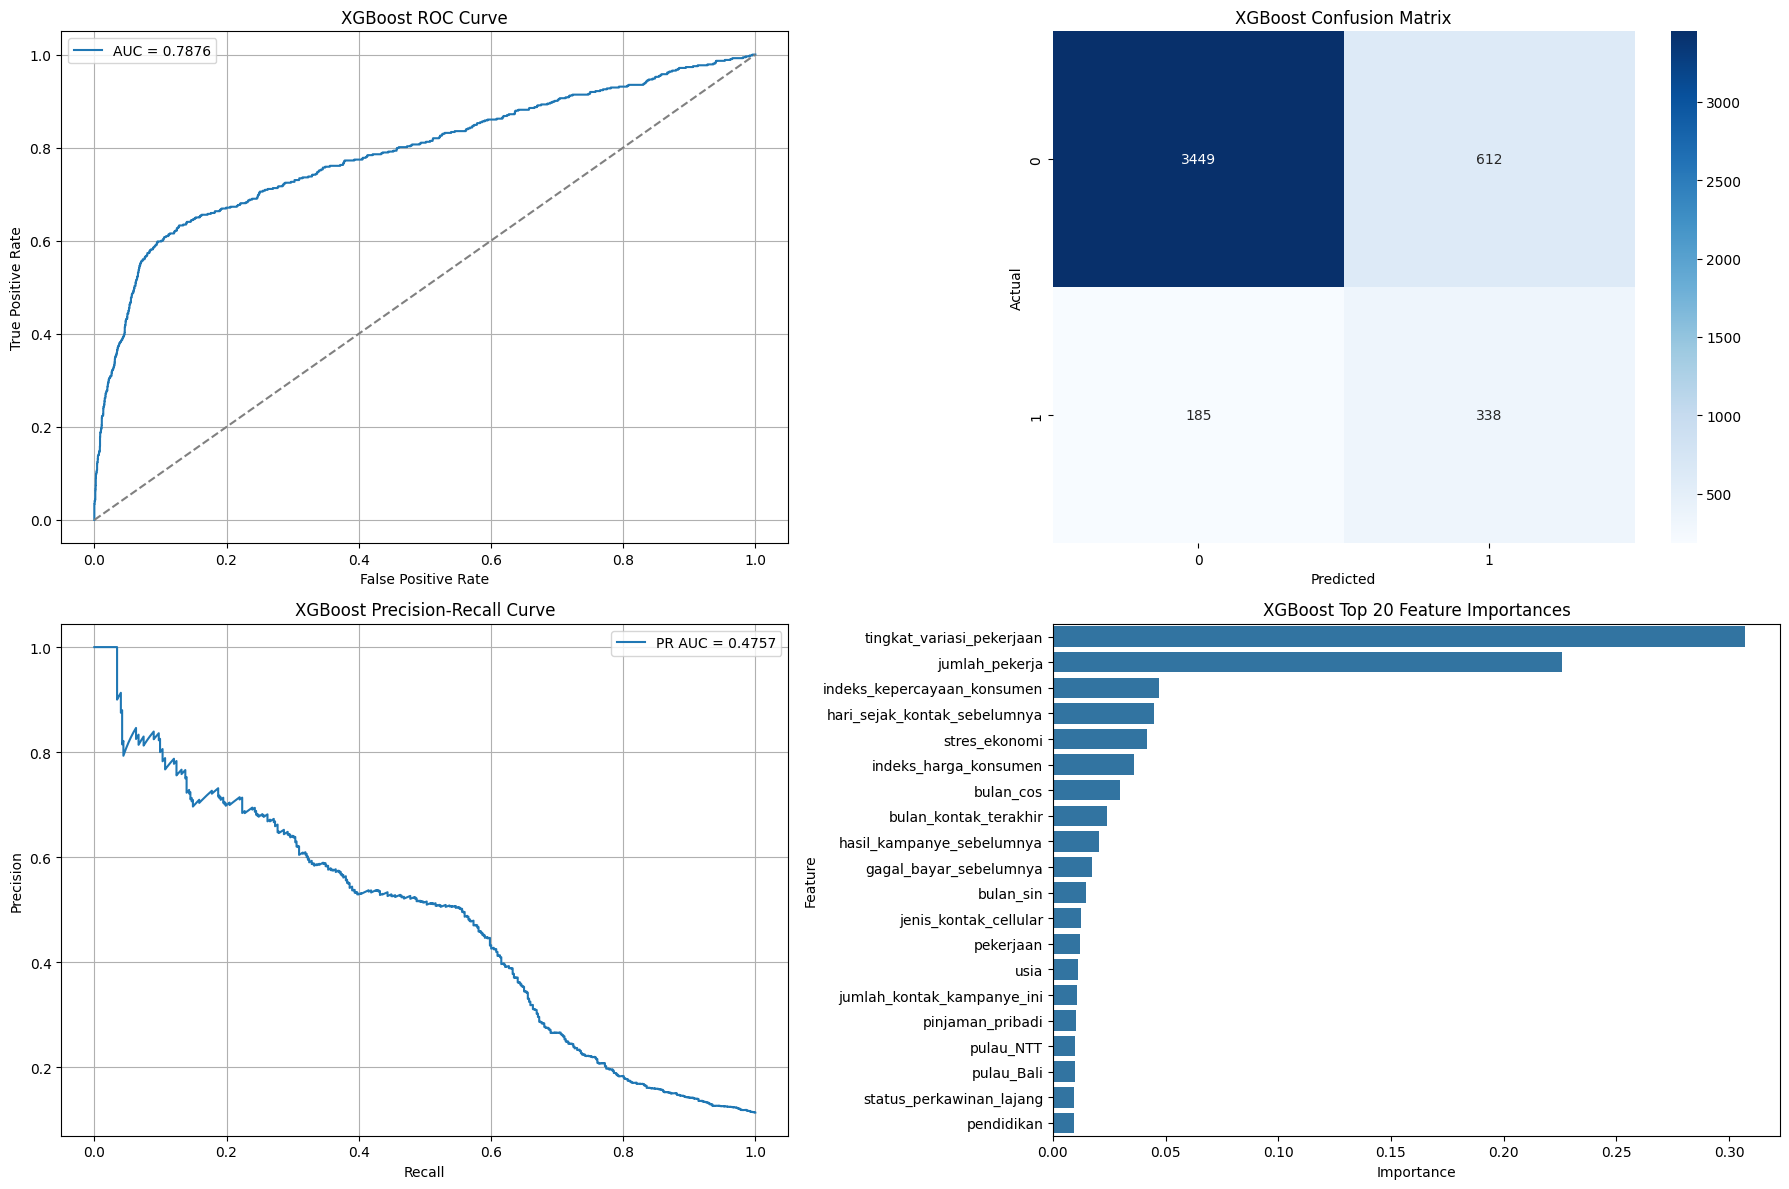


Model: XGBoost
[AUC] Validation AUC: 0.7876

[Classification Report]
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      4061
           1       0.36      0.65      0.46       523

    accuracy                           0.83      4584
   macro avg       0.65      0.75      0.68      4584
weighted avg       0.88      0.83      0.85      4584


[Precision-Recall AUC]: 0.4757


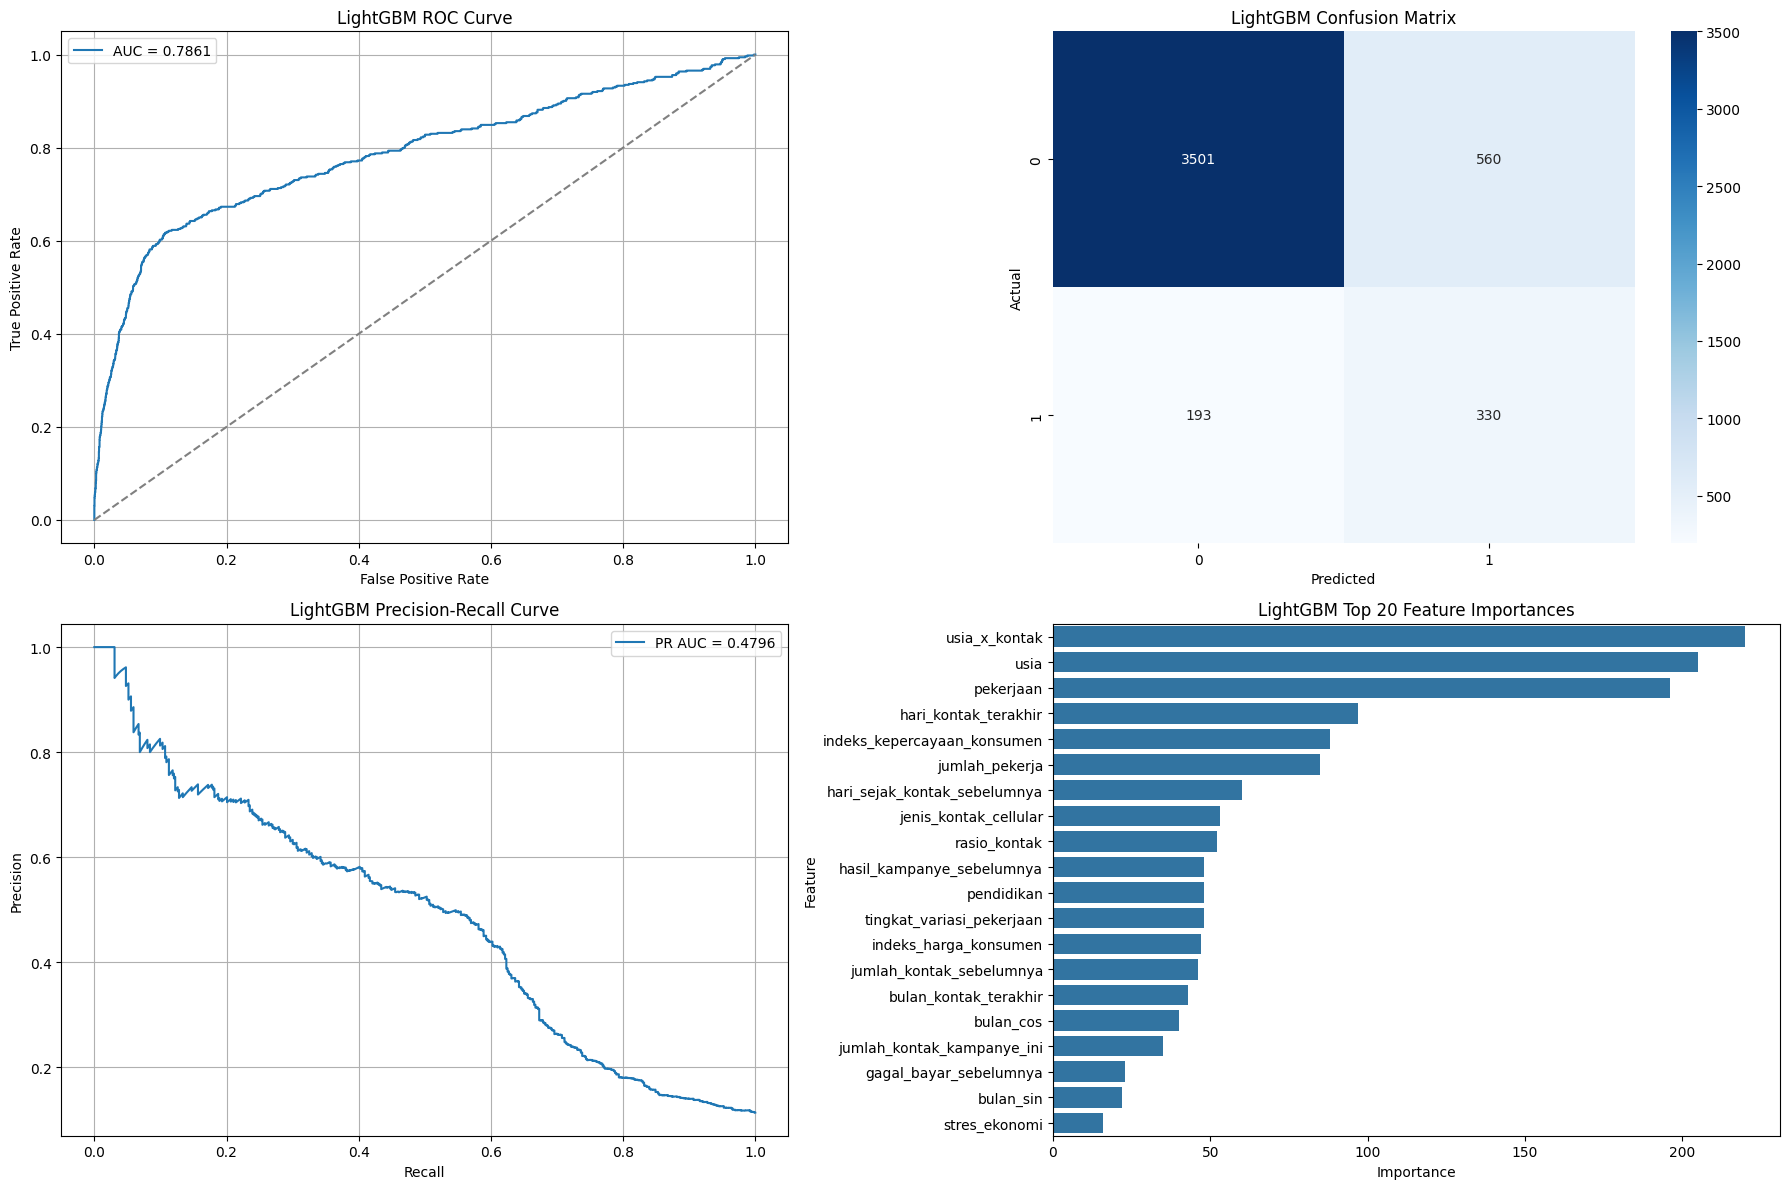


Model: LightGBM
[AUC] Validation AUC: 0.7861

[Classification Report]
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      4061
           1       0.37      0.63      0.47       523

    accuracy                           0.84      4584
   macro avg       0.66      0.75      0.68      4584
weighted avg       0.88      0.84      0.85      4584


[Precision-Recall AUC]: 0.4796


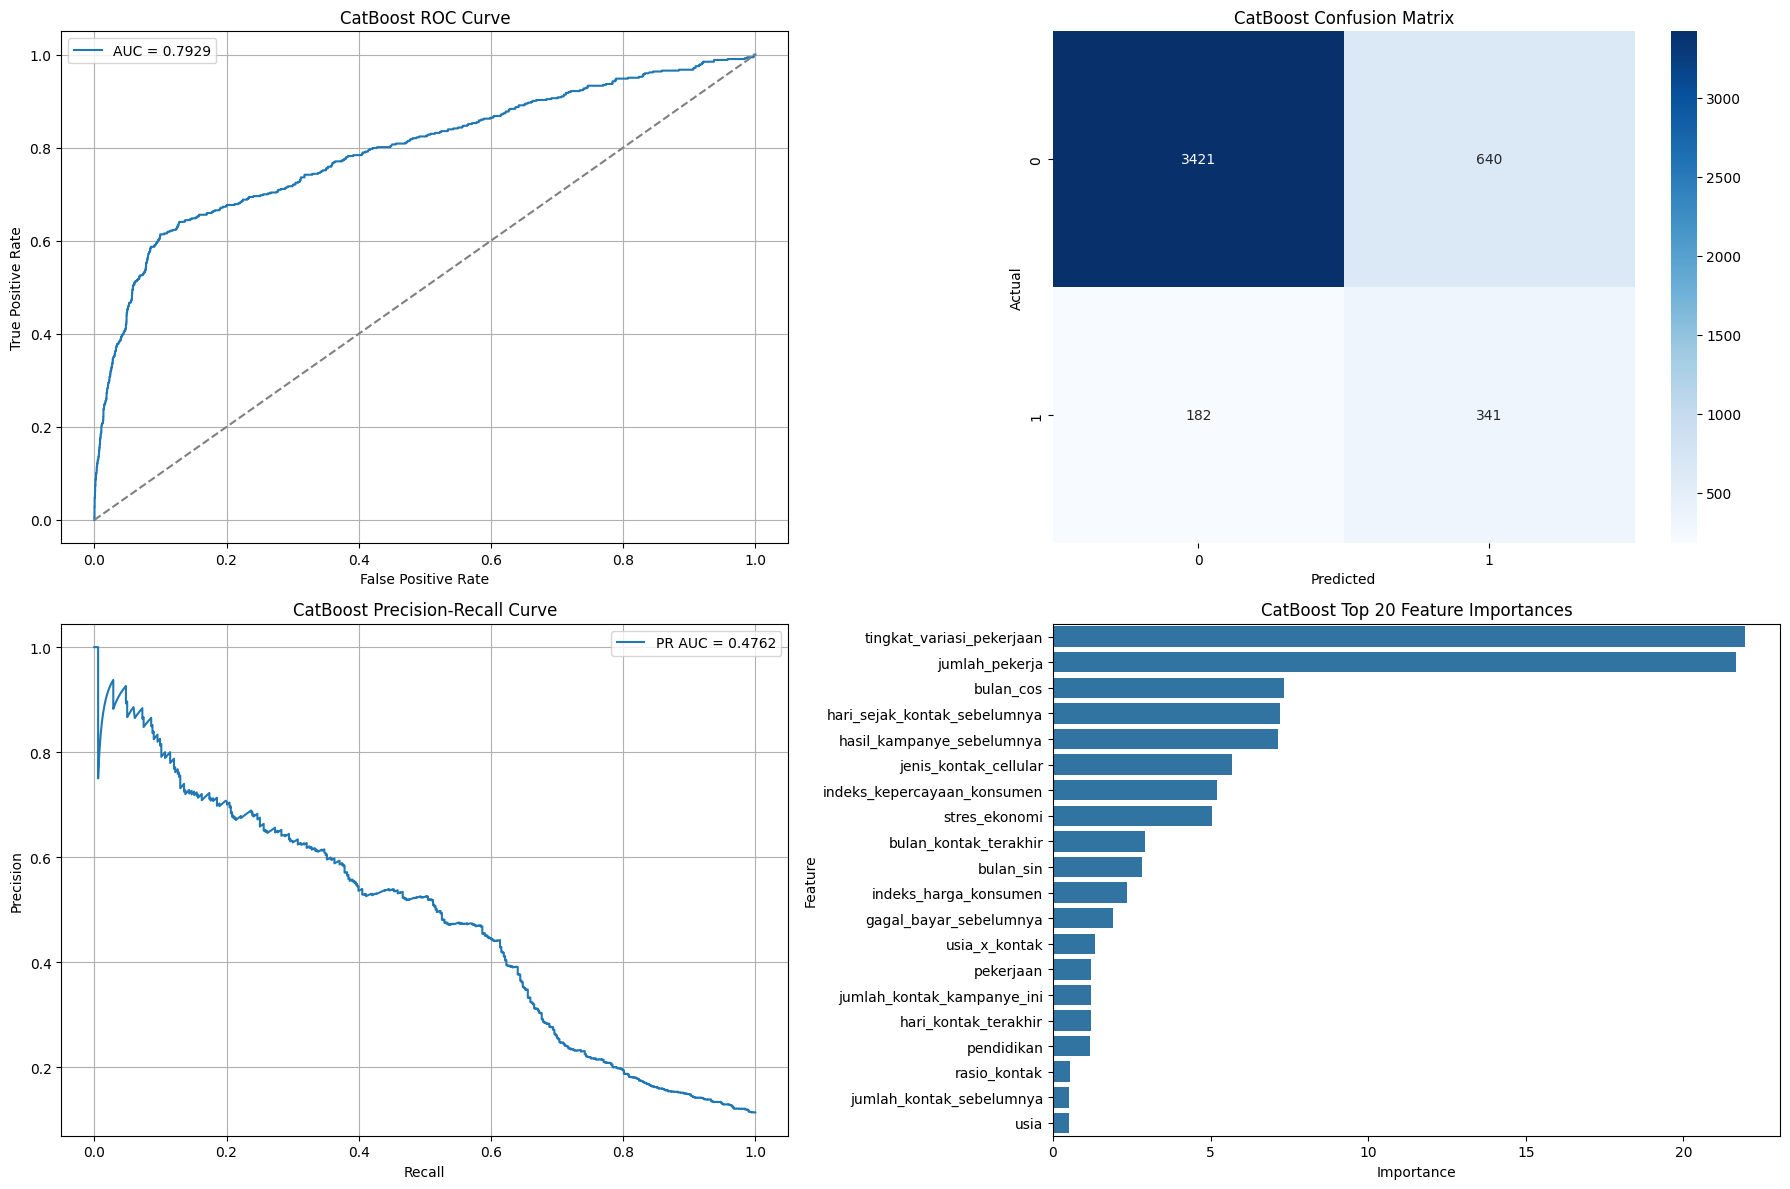


Model: CatBoost
[AUC] Validation AUC: 0.7929

[Classification Report]
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      4061
           1       0.35      0.65      0.45       523

    accuracy                           0.82      4584
   macro avg       0.65      0.75      0.67      4584
weighted avg       0.88      0.82      0.84      4584


[Precision-Recall AUC]: 0.4762


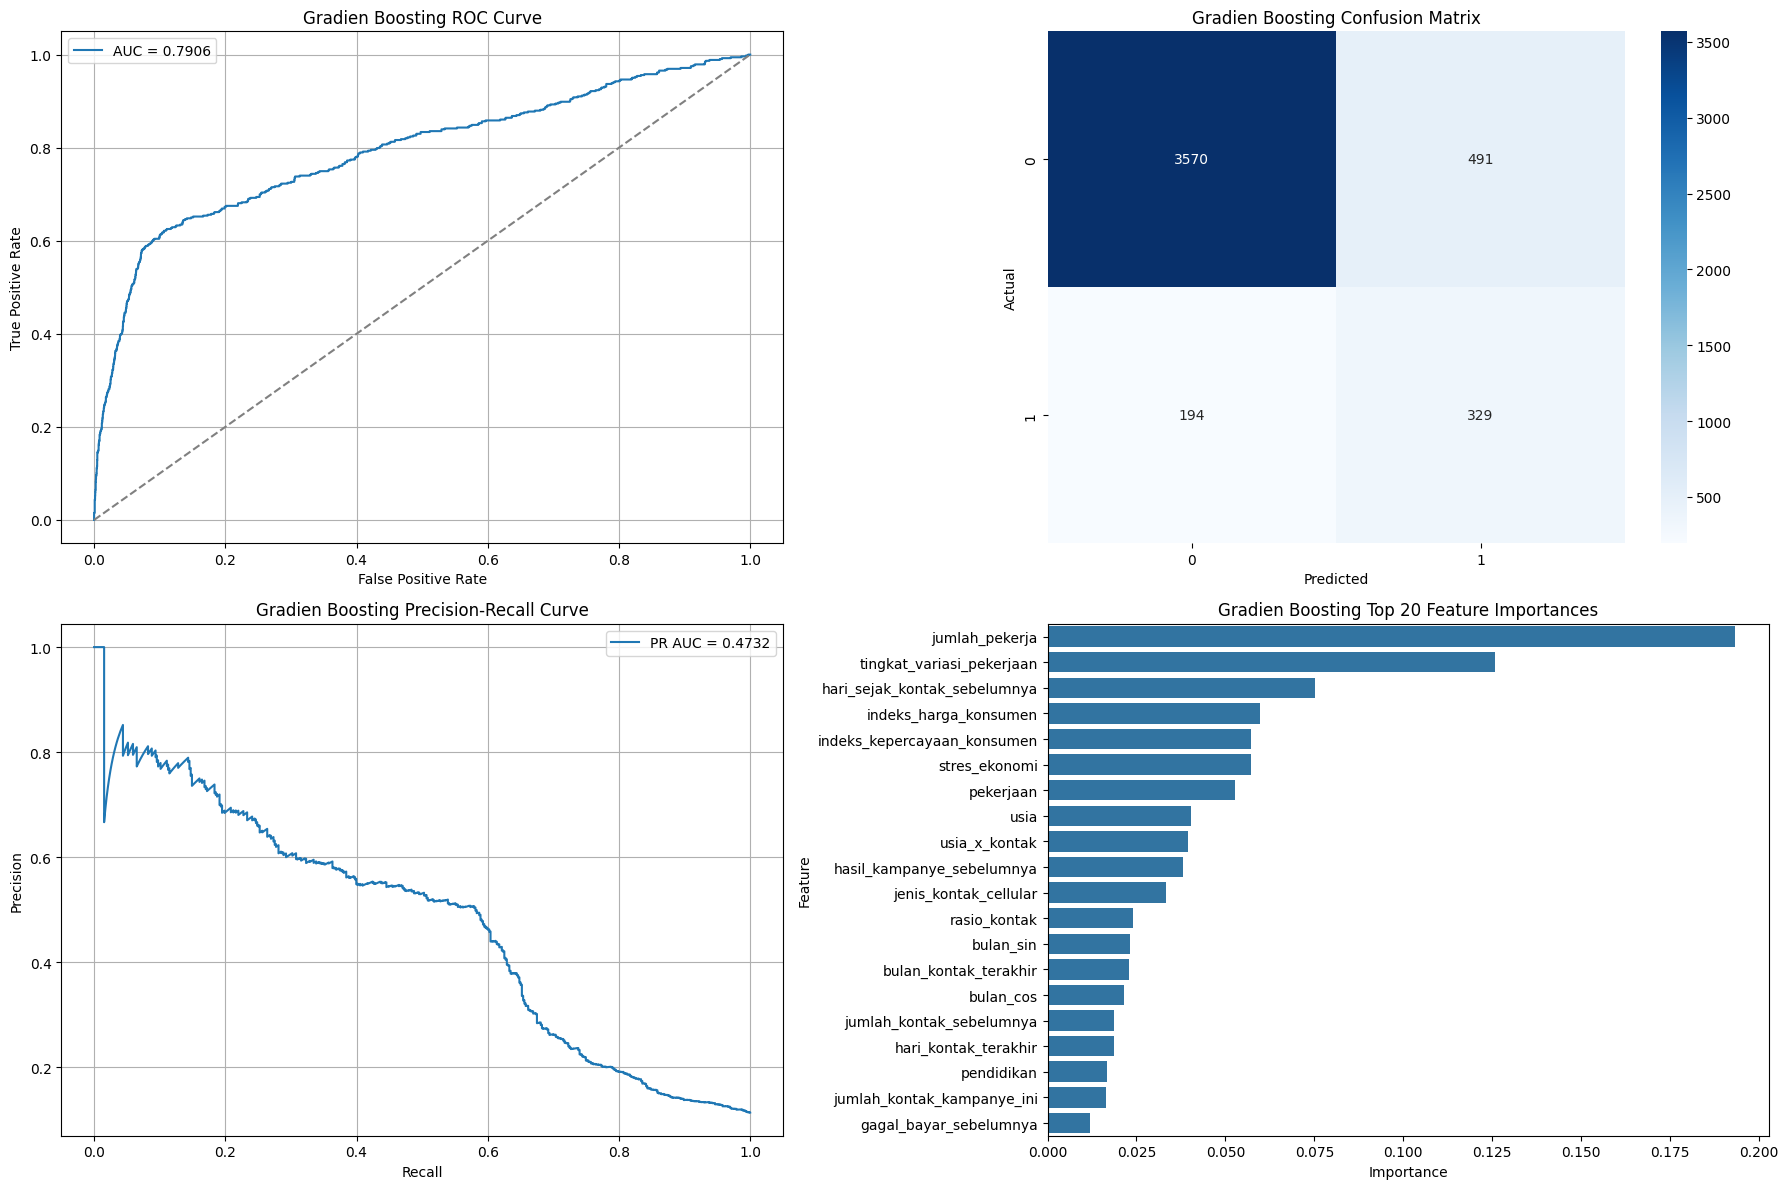


Model: Gradien Boosting
[AUC] Validation AUC: 0.7906

[Classification Report]
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      4061
           1       0.40      0.63      0.49       523

    accuracy                           0.85      4584
   macro avg       0.67      0.75      0.70      4584
weighted avg       0.89      0.85      0.86      4584


[Precision-Recall AUC]: 0.4732


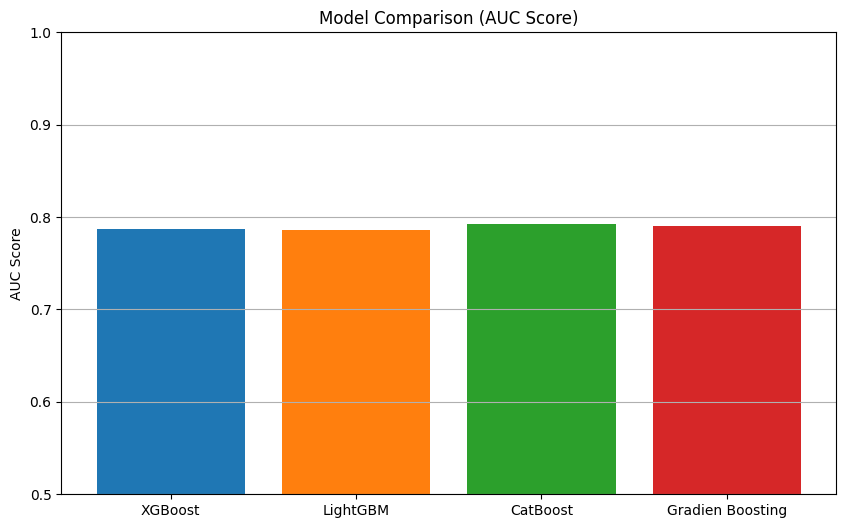

In [119]:
# Evaluate all models
results = []
for model, name in [(xgb_model, "XGBoost"), (lgb_model, "LightGBM"), (cat_model, "CatBoost"), (gbc_model,"Gradien Boosting")]:
    results.append(evaluate_model(model, name, X_valid_eval, y_valid_eval, X_train_eval))

# Additional comparison plot
plt.figure(figsize=(10, 6))
for res in results:
    plt.bar(res['model_name'], res['auc'], label=f"AUC: {res['auc']:.4f}")
plt.title("Model Comparison (AUC Score)")
plt.ylabel("AUC Score")
plt.ylim(0.5, 1.0)
plt.grid(True, axis='y')
plt.show()

# 🫱🏻‍🫲🏾 Ensemble

In [ ]:
# Hitung scale_pos_weight = negatif / positif
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
import pandas as pd

# Use the average best iterations obtained from the previous stability checks
lgb_final_params = lgb_params.copy()
lgb_final_params.update({'n_estimators': 25}) # Replace with the average best iteration from your output

xgb_final_params = xgb_params.copy()
xgb_final_params.update({'n_estimators': 59, 'use_label_encoder': False}) # Replace with the average best iteration from your output

cat_final_params = cat_params.copy()
cat_final_params.update({'iterations': 39, 'verbose': False}) # Replace with the average best iteration from your output

# Model individual
clf_lgb = lgb.LGBMClassifier(**lgb_final_params)
clf_cat = CatBoostClassifier(**cat_final_params)
clf_xgb = xgb.XGBClassifier(**xgb_final_params)
clf_gbc = GradientBoostingClassifier(**gbc_params)

# Ensemble: All models
voting_all = VotingClassifier(
    estimators=[('lgb', clf_lgb), ('cat', clf_cat), ('xgb', clf_xgb), ('gbc', clf_gbc)],
    voting='soft'
)

# Ensemble: Only LightGBM + CatBoost (model yang kamu lebih percaya)
voting_lgb_cat = VotingClassifier(
    estimators=[('lgb', clf_lgb), ('cat', clf_cat)],
    voting='soft'
)

# Ensemble: Weighted voting (misal kamu beri bobot lebih tinggi ke LGBM & CatBoost)
voting_weighted = VotingClassifier(
    estimators=[('lgb', clf_lgb), ('cat', clf_cat), ('xgb', clf_xgb), ('gbc', clf_gbc)],
    voting='soft',
    weights=[2.5, 2.5, 1, 1]
)

# Daftar model
model_dict = {
    'LGBM': clf_lgb,
    'CatBoost': clf_cat,
    'XGBoost': clf_xgb,
    'GradientBoosting': clf_gbc,
    'Voting (All)': voting_all,
    'Voting (LGB+Cat)': voting_lgb_cat,
    'Voting Weighted': voting_weighted
}

# Evaluasi semua model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=47)
results = {}

for name, model in model_dict.items():
    scores = cross_val_score(model, X_train_final, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    results[name] = {
        'Mean AUC': scores.mean(),
        'Std AUC': scores.std()
    }

# Tampilkan sebagai dataframe
results_df = pd.DataFrame(results).T.sort_values(by='Mean AUC', ascending=False)
print(results_df)


                  Mean AUC   Std AUC
Voting Weighted   0.793836  0.013259
Voting (All)      0.793736  0.013419
Voting (LGB+Cat)  0.793669  0.013073
CatBoost          0.792882  0.014014
GradientBoosting  0.792504  0.015072
LGBM              0.791532  0.012321
XGBoost           0.791434  0.013776


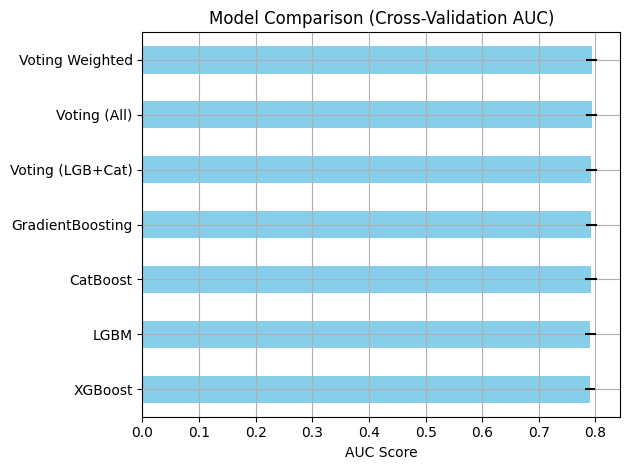

In [ ]:
import matplotlib.pyplot as plt

results_df['Mean AUC'].plot(kind='barh', xerr=results_df['Std AUC'], color='skyblue')
plt.xlabel("AUC Score")
plt.title("Model Comparison (Cross-Validation AUC)")
plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#  🏁 Final Model & Submission

In [121]:
lgb_params

{'learning_rate': 0.044167537658806336,
 'num_leaves': 38,
 'max_depth': 5,
 'feature_fraction': 0.6478043535801732,
 'bagging_fraction': 0.8237103671209042,
 'bagging_freq': 4,
 'min_child_samples': 23,
 'lambda_l1': 0.8560415565533104,
 'lambda_l2': 1.0182550917756634,
 'objective': 'binary',
 'n_estimators': 72,
 'metric': 'auc',
 'boosting_type': 'gbdt',
 'verbosity': -1,
 'scale_pos_weight': np.float64(7.7666411629686305),
 'random_state': 42,
 'n_jobs': -1}

In [123]:
# Train final model on full training data
best_model = lgb.LGBMClassifier(**lgb_params)

# CatBoostEncoder per fold
cbe = CatBoostEncoder(cols=['pekerjaan'], random_state=42)
X_train_final['pekerjaan'] = cbe.fit_transform(X_train_final['pekerjaan'], y_train)
X_test_final['pekerjaan'] = cbe.transform(X_test_final['pekerjaan'])

best_model.fit(X_train_final, y_train)

LGBMClassifier(bagging_fraction=0.8237103671209042, bagging_freq=4,
               feature_fraction=0.6478043535801732,
               lambda_l1=0.8560415565533104, lambda_l2=1.0182550917756634,
               learning_rate=0.044167537658806336, max_depth=5, metric='auc',
               min_child_samples=23, n_estimators=72, n_jobs=-1, num_leaves=38,
               objective='binary', random_state=42,
               scale_pos_weight=np.float64(7.7666411629686305), verbosity=-1)

In [124]:
import pandas as pd

# predict probability
y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]

# create submission file
submission = pd.DataFrame({
    "customer_number": df_val_clean["customer_number"],  # asumsi urutan sudah sesuai X_test_final
    "berlangganan_deposito": y_pred_proba
})

# Simpan ke file CSV
submission.to_csv("DCM_DMU_2025_Model_OneHotEnjoyer.csv", index=False)

print("✅ File submission berhasil disimpan sebagai 'DCM_DMU_2025_Model_OneHotEnjoyer.csv'")


✅ File submission berhasil disimpan sebagai 'DCM_DMU_2025_Model_OneHotEnjoyer.csv'


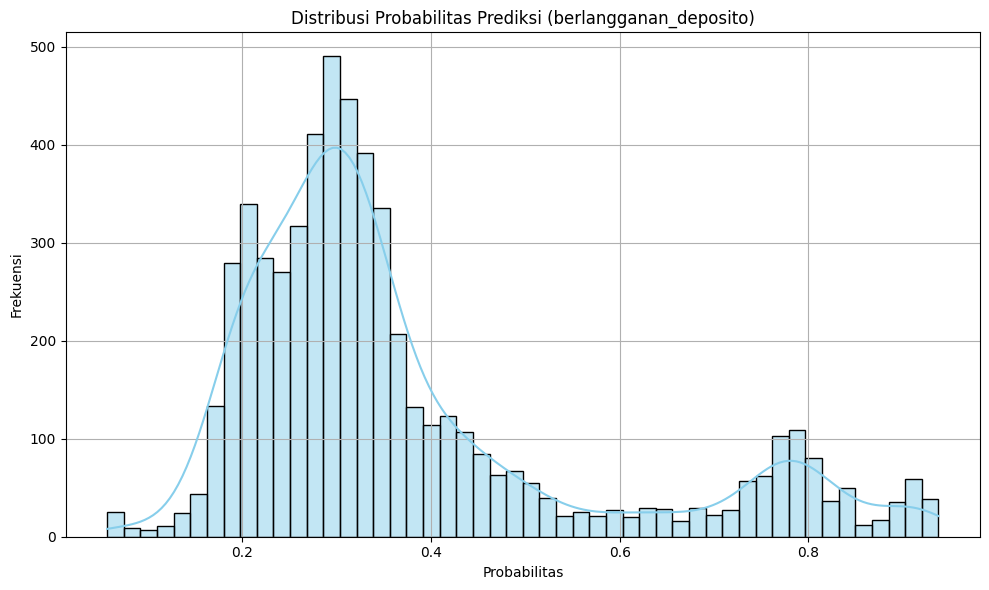

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, bins=50, kde=True, color='skyblue')
plt.title("Distribusi Probabilitas Prediksi (berlangganan_deposito)")
plt.xlabel("Probabilitas")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.tight_layout()
plt.show()


In [126]:
submission.shape, df_val_clean.shape

((5729, 2), (5729, 41))

In [127]:
submission

,customer_number,berlangganan_deposito
0,445420,0.275414
1,585604,0.220585
2,888824,0.223703
3,816820,0.131986
4,542716,0.387839
...,...,...
5724,782072,0.257404
5725,116371,0.269612
5726,773759,0.175999
5727,612330,0.145874
